In [8]:
import albumentations as alb
import tensorflow as tf
from functools import partial
import cv2
import os
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from utils import get_base_transforms, get_tf_dataset, get_train_transforms, plot_fine, plot_model

Check for GPU

In [3]:
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Dataset Loading, Augmentation and Plotting

In [5]:
aug_en = get_train_transforms(img_size=224, p=1.0)
base_aug_en = get_base_transforms(img_size=224)

train_dataset_en = get_tf_dataset(
    "train",
    aug_en
)
val_dataset_en = get_tf_dataset(
    "val",
    base_aug_en,
    shuffle=False
)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Found 71178 files belonging to 2 classes.
Found 9628 files belonging to 2 classes.


In [6]:
aug_en_ = get_train_transforms(img_size=224, p=.5)
train_dataset_en_ = get_tf_dataset(
    "train",
    aug_en_
)

Found 71178 files belonging to 2 classes.


Callback and Early Stopping for regularization

In [10]:
current_dir = os.getcwd()
checkpoint_filepath = current_dir+'/tmp_checkpoint'
if not os.path.exists(checkpoint_filepath):
    print('Creating Directory: ' + checkpoint_filepath)
    os.makedirs(checkpoint_filepath)
    
def get_callbacks(model_name=None):
    name = f"{model_name}.h5"
    custom_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            mode = 'min',
            patience = 3,
            verbose = 1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath = os.path.join(checkpoint_filepath, name),
            monitor = 'val_loss',
            mode = 'min',
            verbose = 1,
            save_best_only = True
        )
    ]
    return custom_callbacks

Model building

In [11]:
def create_model_efficient_net(lr, decay):
    # Laden des EfficientNetV2-Modells (ohne den fully connected layer am Ende)
    base_model = keras.applications.EfficientNetV2S(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(224, 224, 3),
                                                    include_preprocessing= False)

    base_model.trainable = False

    # Eingabebild reskalieren
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)

    # Ausgabe des letzten Convolutional Layers des vortrainierten Modells
    x = base_model(x, training=False)
    
     #hinzufügen des klassifikations layers
    x = tf.keras.layers.Conv2D(500, 1, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.2) (x) # Dropout Layer zur Regularisierung hinzufügen
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(500, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2) (x)
    
    # Ausgabe-Layer mit der gewünschten Anzahl von Klassen
    predictions = tf.keras.layers.Dense(1)(x)

    # Erstellen des Modells
    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="EfficientNetV2-S")
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"])

    return base_model, model

In [20]:
base_learning_rate = 1e-3 # oder 1e-3 1e-4
decay = 1e-5
base_model, model = create_model_efficient_net(base_learning_rate, decay)
model.summary()

Model: "EfficientNetV2-S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 500)         640500    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 500)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 500)    

Transfer Learning

Heavy augmentation

In [21]:
initial_epochs = 5 # @param {type: "slider", min:1, max:30}
callback = get_callbacks("transfer_en_ho_aug_h")
history = model.fit(train_dataset_en,
                    epochs=initial_epochs,
                    validation_data=val_dataset_en,
                   callbacks=callback)

Epoch 1/5
2225/2225 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9439
Epoch 1: val_loss improved from inf to 0.06466, saving model to /notebooks/tmp_checkpoint/transfer_en_ho_aug_h.h5
2225/2225 [==============================] - 391s 168ms/step - loss: 0.1317 - accuracy: 0.9439 - val_loss: 0.0647 - val_accuracy: 0.9838
Epoch 2/5
2225/2225 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9686
Epoch 2: val_loss improved from 0.06466 to 0.05766, saving model to /notebooks/tmp_checkpoint/transfer_en_ho_aug_h.h5
2225/2225 [==============================] - 379s 170ms/step - loss: 0.0749 - accuracy: 0.9686 - val_loss: 0.0577 - val_accuracy: 0.9883
Epoch 3/5
2225/2225 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9737
Epoch 3: val_loss improved from 0.05766 to 0.04958, saving model to /notebooks/tmp_checkpoint/transfer_en_ho_aug_h.h5
2225/2225 [==============================] - 377s 169ms/step - loss: 0.0637 - accurac

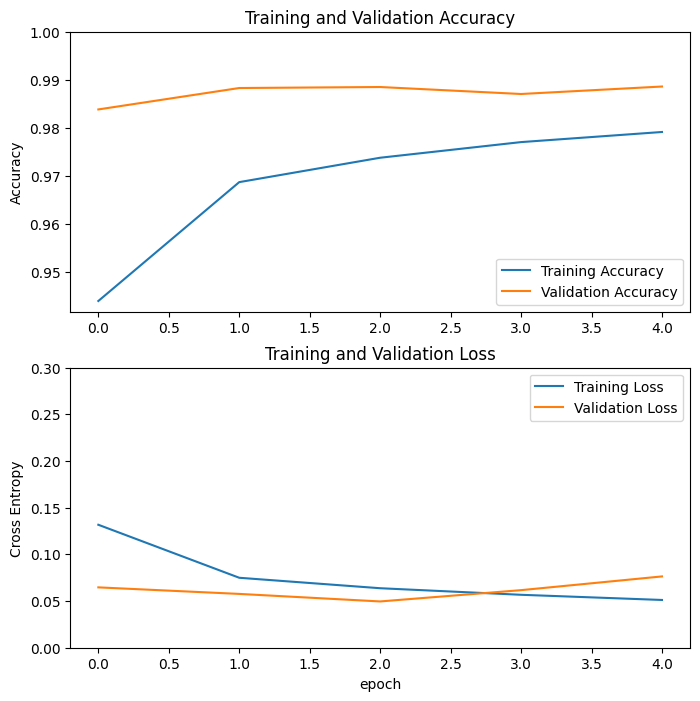

In [22]:
plot_model(history)

Light augmentation

In [15]:
callback_aug_l = get_callbacks("transfer_en_ho_aug_l")
base_model_2, model_2 = create_model_efficient_net(base_learning_rate, decay)
history_aug_l = model_2.fit(train_dataset_en_,
                    epochs=initial_epochs,
                    validation_data=val_dataset_en,
                   callbacks=callback)

Epoch 1/5
2225/2225 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9572
Epoch 1: val_loss did not improve from 0.05470
2225/2225 [==============================] - 379s 163ms/step - loss: 0.1032 - accuracy: 0.9572 - val_loss: 0.0640 - val_accuracy: 0.9828
Epoch 2/5
2225/2225 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9786
Epoch 2: val_loss did not improve from 0.05470
2225/2225 [==============================] - 362s 162ms/step - loss: 0.0526 - accuracy: 0.9786 - val_loss: 0.0825 - val_accuracy: 0.9807
Epoch 3/5
2225/2225 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9810
Epoch 3: val_loss did not improve from 0.05470
2225/2225 [==============================] - 376s 169ms/step - loss: 0.0453 - accuracy: 0.9810 - val_loss: 0.1044 - val_accuracy: 0.9723
Epoch 4/5
2225/2225 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9844
Epoch 4: val_loss did not improve from 0.05470
2225/2225 [==

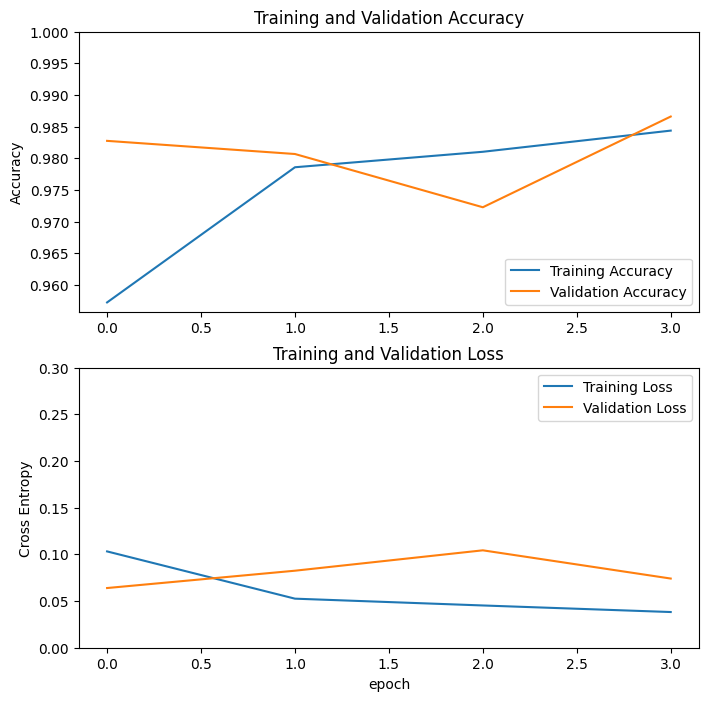

In [16]:
plot_model(history_aug_l)

Finetuning

In [26]:
def unfreeze_model(model, lr, decay):
    print("Number of layers in the base model: ", len(base_model.layers))
    model.trainable = True
    set_trainable = False

    for layer in model.layers:
      if layer.name == 'block6f_expand_conv': ##block6a_expand_conv, block6d_se_excite
          set_trainable = True
      if set_trainable:
          if not isinstance(layer, tf.keras.layers.BatchNormalization):
              layer.trainable = True
          else:
              layer.trainable = False
      else:
          layer.trainable = False

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay) #decay = power scheduling; momentum = optimierer
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [27]:
finetune_lr = 10 #@param {type:"slider", min:0, max:10000, step:100}
unfreeze_model(base_model, base_learning_rate/finetune_lr, decay)

model.summary()

Number of layers in the base model:  512
Model: "EfficientNetV2-S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 500)         640500    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 500)        0         
 2D)                                                             
                                                                 
 dropout_

In [28]:
finetune_epochs = 10 # @param {type: "slider", min:1, max:30}
callback = get_callbacks("en_final_aug_h")
history_fine = model.fit(train_dataset_en,
                    epochs=initial_epochs+finetune_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=val_dataset_en,
                    callbacks = callback)

Epoch 5/15
2225/2225 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9803
Epoch 5: val_loss improved from inf to 0.07804, saving model to /notebooks/tmp_checkpoint/en_final_aug_h.h5
2225/2225 [==============================] - 374s 168ms/step - loss: 0.0487 - accuracy: 0.9803 - val_loss: 0.0780 - val_accuracy: 0.9840
Epoch 6/15
2225/2225 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9805
Epoch 6: val_loss did not improve from 0.07804
2225/2225 [==============================] - 374s 167ms/step - loss: 0.0478 - accuracy: 0.9805 - val_loss: 0.0858 - val_accuracy: 0.9841
Epoch 7/15
2225/2225 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9825
Epoch 7: val_loss improved from 0.07804 to 0.07657, saving model to /notebooks/tmp_checkpoint/en_final_aug_h.h5
2225/2225 [==============================] - 378s 169ms/step - loss: 0.0432 - accuracy: 0.9825 - val_loss: 0.0766 - val_accuracy: 0.9886
Epoch 8/15
2225/2225 [======

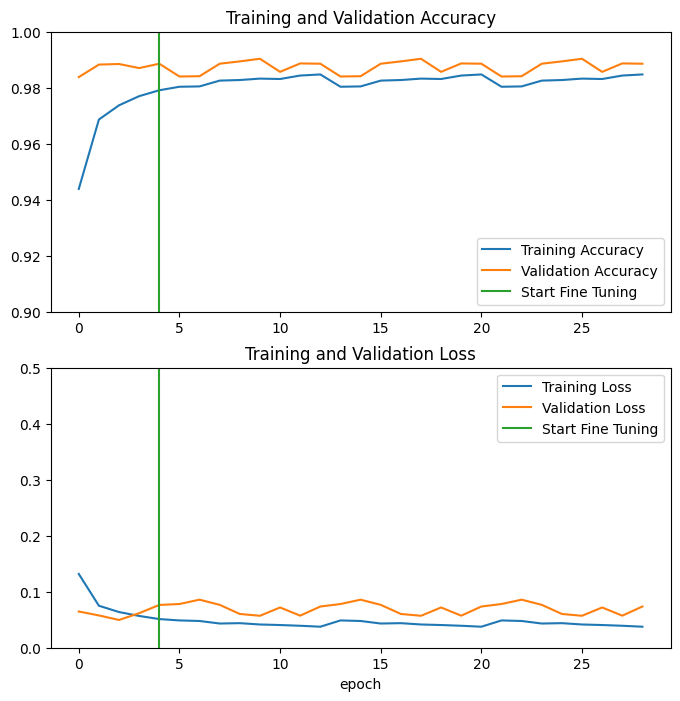

In [33]:
acc, val_acc, loss, val_loss = history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']
plot_fine(history_fine, acc, val_acc, loss, val_loss, initial_epochs)

Save the Model

In [ ]:
model.save('saved_models/my_en')